### Mateusz Kądziela, 148271
### Mateusz Serek, 148284
Source code and more readable pseudocode available [here](https://github.com/MatKadd/EC_2023/tree/main/lab7).

In [1]:
import pandas as pd
import time
import numpy as np
from prettytable import PrettyTable 
from numba.typed import List
from numba import jit
from random import random

In [2]:
from visualizations import visualize_solution, visualize_stats
from utils import calculate_distances, evaluate_solution
from algorithms import get_random_solution, get_edge_neigh, steepest

# Read data and calculate distances

In [3]:
C = pd.read_csv("../data/TSPC.csv", sep=";", header=None)
C.name = "Instance C"

instances = [C]

In [4]:
distances = calculate_distances(C)

In [5]:
@jit(nopython=True)
def local_search(solution, neigh_type, distances):
    while True:
        neigh = neigh_type(solution)
        solution, improvement = steepest(solution, neigh, distances)
        if improvement == 0:
            break
    return solution

# Destroy and repair

For our destroy operation, we chose random deletion of nodes. We go over the solution and with 0.3 probability we delete each node. Next we go over the destroyed solution. For each existing node, we check, if the next node in the solution is empty. If it is, we look for the closest node and put it in this place.

In [6]:
@jit(nopython=True)
def del_and_repair(solution, distances):
    solution = solution.copy()
    for i, node in enumerate(solution[1:]):
        if random() < 0.3:
            solution[i] = -1
    inside_nodes = set(solution)
    inside_nodes.remove(-1)
    outside_nodes = set(range(200)) - inside_nodes
    
    for i, node in enumerate(solution):
        best = None
        best_dist = 1e9
        if solution[(i+1)%100] == -1:
            for out_node in outside_nodes:
                dist = distances[node, out_node]
                if dist < best_dist:
                    best_dist = dist
                    best = out_node
            solution[(i+1)%100] = best
            outside_nodes.remove(best)
    return solution

The search runs for 14s, since that was the time MSLS in previous labs run for. As a starting solution we use randomly generated one.

In [7]:
def LSNS(start_solution, neigh_type, perturbation, distances, ls=True):
    start = time.perf_counter()
    solution = start_solution()
    solution = local_search(solution, neigh_type, distances)
    current_score = evaluate_solution(solution, distances)
    count = 1
    while (time.perf_counter()-start < 14):
        new_solution = perturbation(solution, distances)
        if ls:
            new_solution = local_search(new_solution, neigh_type, distances)
        count += 1
        score = evaluate_solution(new_solution, distances)
        if score < current_score:
            current_score = score
            solution = new_solution
    return solution, current_score, count

Min score for local search:False: 49598
Max score for local search:False: 52106
Avg score for local search:False: 50743.0


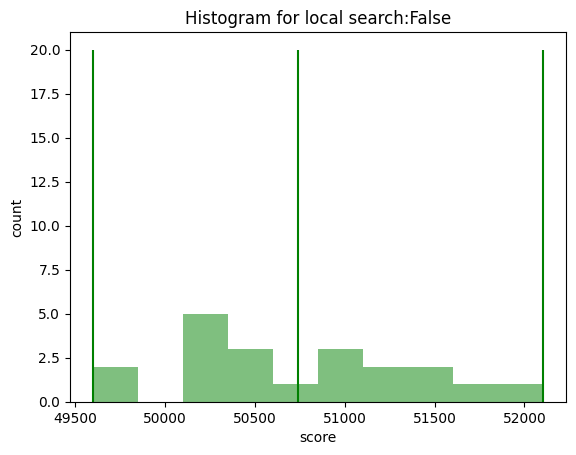

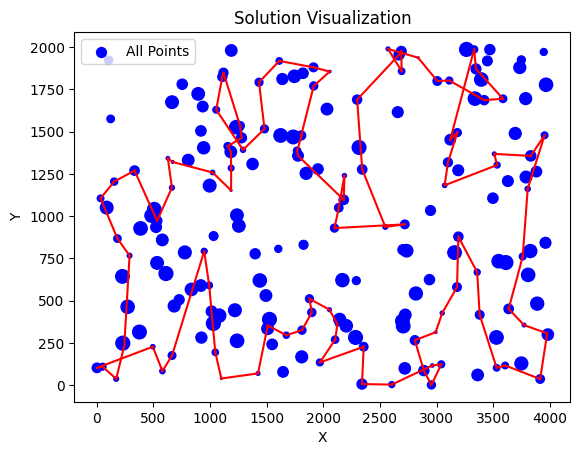

Min score for local search:True: 46961
Max score for local search:True: 47453
Avg score for local search:True: 47182.9


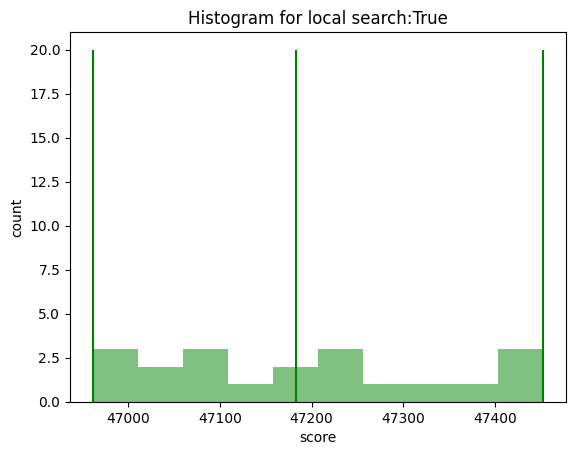

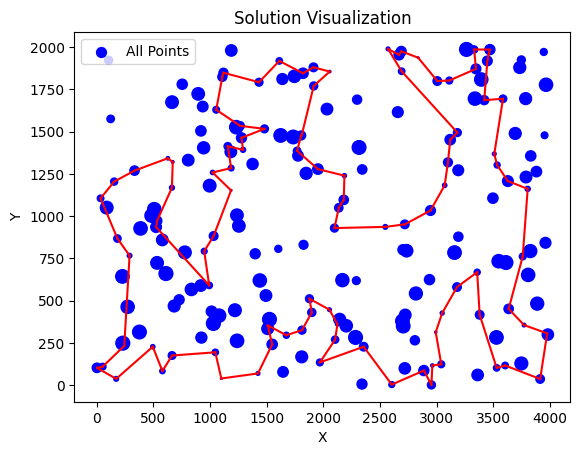

In [10]:
local = [False, True]
avg_scores = []
final_counts = []
for val in local:
    solutions = []
    for i in range(20):
        solution, score, count = LSNS(get_random_solution, get_edge_neigh, del_and_repair, distances, ls=val)
        solutions.append((solution, score, count))
    scores = [solution[1] for solution in solutions]
    lsns_avg_score = np.mean(scores)
    avg_scores.append(lsns_avg_score)
    counts = [solution[2] for solution in solutions]
    avg_counts = np.mean(counts)
    final_counts.append(avg_counts)
    visualize_stats(scores, 'local search:' + str(val))
    visualize_solution(C, min(solutions, key=lambda solution: solution[1])[0])

In [11]:
table = PrettyTable(["Method", "Average number of iterations of main loop"]) 
table.add_row(['ILS', 3246.75])
table.add_row(['LSNS-with-ls', final_counts[1]])
table.add_row(['LSNS-with-no-ls', final_counts[0]])
print(table)

+-----------------+-------------------------------------------+
|      Method     | Average number of iterations of main loop |
+-----------------+-------------------------------------------+
|       ILS       |                  3246.75                  |
|   LSNS-with-ls  |                   1946.3                  |
| LSNS-with-no-ls |                 314455.95                 |
+-----------------+-------------------------------------------+


In [13]:
table = PrettyTable(["Method", "Avg time for one solution", "Avg score for method"]) 
table.add_row(['MSLS', 14, 49116.5])
table.add_row(['ILS', 14, 47282.55])
table.add_row(['LSNS-with-ls', 14, avg_scores[1]])
table.add_row(['LSNS-with-no-ls', 14, avg_scores[0]])
print(table)

+-----------------+---------------------------+----------------------+
|      Method     | Avg time for one solution | Avg score for method |
+-----------------+---------------------------+----------------------+
|       MSLS      |             14            |       49116.5        |
|       ILS       |             14            |       47282.55       |
|   LSNS-with-ls  |             14            |       47182.9        |
| LSNS-with-no-ls |             14            |       50743.0        |
+-----------------+---------------------------+----------------------+


# Conclusions

LSNS without using local search after each destroy and repair operation is worse than the one using local search after them. It is to be expected but the values obtained without using local search are still quite good. When we compare them to iterative local search, they perform quite similarly to it. Our ILS was more of a LSNS to start with, so the improvement was marginal.